### Imports

In [1]:
%matplotlib inline
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

DATASET_PATH = '../data/augmented/'
TEST_DATASET_PATH = '../data/test/'

### Read augmented images from folder

In [4]:
def read_files(path):
    files = os.listdir(path)
    rawx=[]
    rawy=[]
    random.shuffle(files)
    for file in files:
        img = cv2.imread(os.path.join(path,file),cv2.IMREAD_GRAYSCALE)
        rawx.append(img)
        rawy.append(int(file.split('_')[1]))
    h, w, l  = rawx[0].shape
    rawx = np.asarray(rawx)
    rawy = np.asarray(rawy)
    rawx = rawx.reshape(len(files),h, w, 1)
    rawx = rawx / 255.
    return rawx, rawy, h, w

In [5]:
xtrain, ytrain, im_h, im_w = read_files(DATASET_PATH)
num_classes = len(np.unique(ytrain))

In [6]:
np.unique(ytrain, return_counts=True)

(array([0, 1, 2, 3, 4, 5]),
 array([1500, 1500, 1500, 1500, 1500, 1500], dtype=int64))

### Read test images from originals_test folder

In [7]:
xtest, ytest, im_h, im_w = read_files(TEST_DATASET_PATH)

### Check how the images looks like

In [8]:
def plot_6_images(xt,yt):
    
    idxs = [ random.randint(0,len(xt)) for i in range(0,6)]
    plt.figure(figsize=(10,5))
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.imshow(xt[idxs[i]].reshape(im_w,im_h),cmap='gray')
        plt.title('y={}'.format(yt[idxs[i]]))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()  

ValueError: cannot reshape array of size 30000 into shape (100,100)

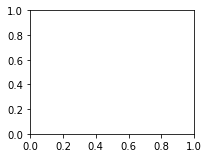

In [9]:
plot_6_images(xtrain,ytrain)

### Create Keras CNN Model

In [10]:
from keras.backend import clear_session

clear_session()
model = None

Using TensorFlow backend.


In [11]:
from keras.utils import to_categorical

ytrain_cat = to_categorical(ytrain, num_classes)
ytest_cat = to_categorical(ytest, num_classes)

In [12]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.losses import categorical_crossentropy
from keras.optimizers import SGD, Adam, Adadelta
from keras.metrics import categorical_accuracy

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',padding='valid', input_shape=(im_w,im_h,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3),padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3),padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.125))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=categorical_crossentropy,
              optimizer=Adadelta(),
              metrics=[categorical_accuracy])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 128)      

### Train CNN

In [13]:
from keras.callbacks import EarlyStopping
EPOC = 25
BS = 64

es = EarlyStopping(monitor='val_loss', mode='min', patience=2, verbose=1)
history = model.fit(xtrain, ytrain_cat, validation_split=0.2, batch_size=BS, epochs=EPOC, callbacks=[es])


Train on 7200 samples, validate on 1800 samples
Epoch 1/25
7200/7200 [==============================] - 18s 2ms/step - loss: 1.7719 - categorical_accuracy: 0.2400 - val_loss: 1.6025 - val_categorical_accuracy: 0.3606
Epoch 2/25
7200/7200 [==============================] - 15s 2ms/step - loss: 1.2002 - categorical_accuracy: 0.5435 - val_loss: 0.7999 - val_categorical_accuracy: 0.7017
Epoch 3/25
7200/7200 [==============================] - 14s 2ms/step - loss: 0.5053 - categorical_accuracy: 0.8301 - val_loss: 0.3523 - val_categorical_accuracy: 0.8811
Epoch 4/25
7200/7200 [==============================] - 15s 2ms/step - loss: 0.2251 - categorical_accuracy: 0.9292 - val_loss: 0.1790 - val_categorical_accuracy: 0.9461
Epoch 5/25
7200/7200 [==============================] - 15s 2ms/step - loss: 0.1359 - categorical_accuracy: 0.9575 - val_loss: 0.1470 - val_categorical_accuracy: 0.9572
Epoch 6/25
7200/7200 [==============================] - 15s 2ms/step - loss: 0.0814 - categorical_accuracy:

In [14]:
history.params

{'batch_size': 64,
 'epochs': 25,
 'steps': None,
 'samples': 7200,
 'verbose': 1,
 'do_validation': True,
 'metrics': ['loss',
  'categorical_accuracy',
  'val_loss',
  'val_categorical_accuracy']}

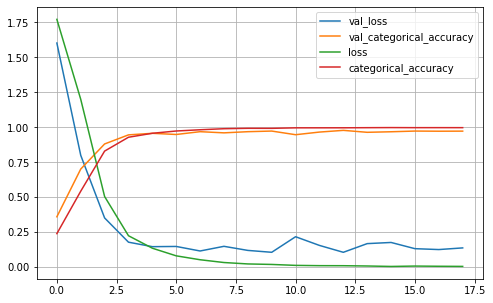

In [15]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca()
plt.show()

### Check accuracy on test dataset

In [16]:
model.evaluate(xtest, ytest_cat)

1800/1800 [==============================] - 1s 506us/step


[1.1068743097947704, 0.8005555272102356]

### Check confusion matrix

In [15]:
import pandas as pd
ypred = model.predict_classes(xtest)

confmatr = pd.crosstab(ytest, ypred, rownames=['True'], colnames=['Predicted'], margins=True)
confmatr

Predicted,0,1,2,3,4,5,All
True,,,,,,,
0,292,3,3,0,2,0,300
1,7,248,39,5,1,0,300
2,10,75,175,39,1,0,300
3,1,18,29,160,64,28,300
4,14,2,21,25,176,62,300
5,0,1,2,4,31,262,300
All,324,347,269,233,275,352,1800


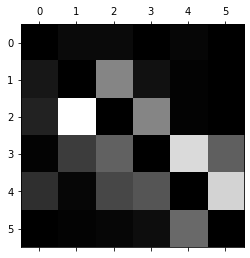

In [16]:
from sklearn.metrics import confusion_matrix

confmatr = confusion_matrix(ytest, ypred)
row_sums = confmatr.sum(axis=1,keepdims=True)
norm_conf_matr = confmatr / row_sums
np.fill_diagonal(norm_conf_matr,0)
plt.matshow(norm_conf_matr,cmap=plt.cm.gray);

### Save model.

In [17]:
model.save('../models/model_cnn.h5')

### Try our model on a never seen before picture (original one)

In [18]:
from keras.models import load_model
mymodel = load_model('../models/model_cnn.h5')

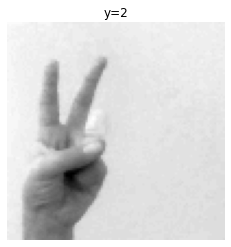

In [19]:
files = os.listdir(TEST_DATASET_PATH)
idx = random.randint(0,len(files)-1)
origimg = cv2.imread(os.path.join(TEST_DATASET_PATH,files[idx]),cv2.IMREAD_GRAYSCALE)

myimg = origimg/255.
myimg = cv2.resize(myimg,(im_h, im_w))
myimg = myimg.reshape(1,im_h, im_w,1)

myclass = mymodel.predict(myimg)
pred = np.argmax(myclass)

plt.imshow(origimg, cmap='gray');
plt.title('y=%d' % pred);
plt.axis('off');


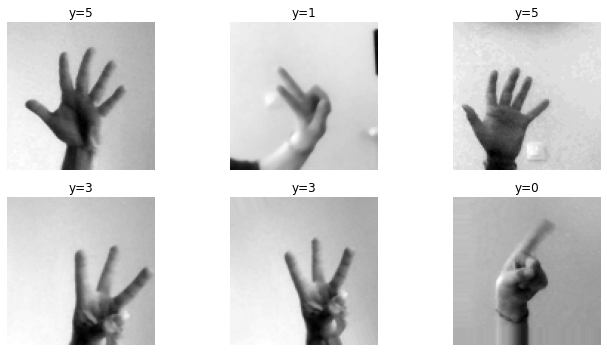

In [20]:
plot_6_images(xtest,ypred)